# Bayesian Inference for Uncertainity Quantificatin for a Nonlinear Model 

In [14]:
import autograd.numpy as np
from autograd import grad
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats as stats
import scipy.optimize as optimize
import arviz as az
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))
print('Running on Arviz v{}'.format(az.__version__))

Running on PyMC3 v3.8
Running on Arviz v0.7.0


### Goal: Utilize PyMC3 Library to explore Bayesian inference on the optimal parameters and uncertainity quantification using a nonlinear function for the cooling of a hot object
#### Netwon's Cooling Law:  $\frac{dT(t)}{dt} = -\frac{1}{\tau}(T(t)-T_{env})$
#### Solution: $T(t) = T_{env} + (T_0 - T_{env})\exp^{\frac{-time}{\tau}}$
#### Initial conditions: $T_{0} = 100$ and $T_{env} = 30$

#### Model Parameter to Estimate: cooling parameter $(\tau)$

In [15]:
def newton_cooling(tau, T_0, T_env, time):
    # T(t)  
    T = T_env + (T_0 - T_env)*np.exp(-time / tau)
    return T


 Assume that data errors are iid and $\epsilon_{i} ~ N(0, \sigma^2) \rightarrow $

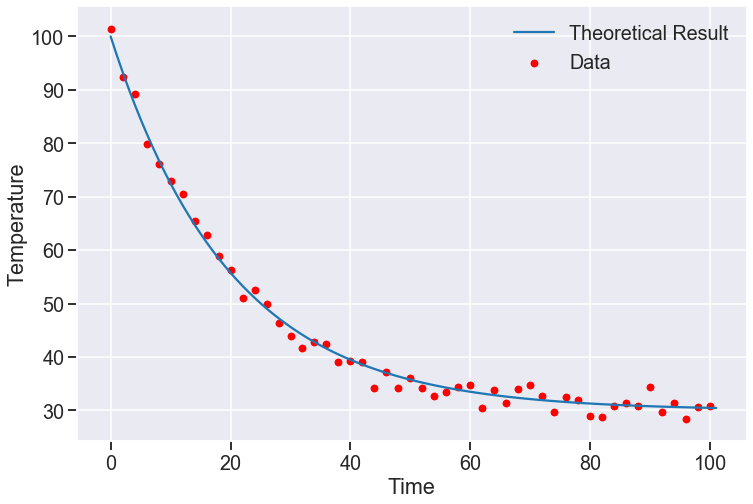

In [16]:
time= np.arange(0,102)
T_0, T_env = 100, 30
tau = 20
T = newton_cooling(20, 100, 30, time)  # perfect or ideal model response


time_data = time[0:-1:2] # every other point
T_data = T[0:-1:2]
sigma_noise  = 1.5  # standard deviation
# noise = stats.norm.rvs(loc=0, scale=sigma_noise, size=len(T_data), random_state=54321)  # normal noise with 0 mean and 1.5 std
noise = stats.norm.rvs(loc=0, scale=sigma_noise, size=len(T_data), random_state=123321)  # normal noise with 0 mean and 1.5 std

T_data += noise

with sns.plotting_context('talk', font_scale=1.2):
    _, axe = plt.subplots(figsize=(12, 8))
    plt.plot(time, newton_cooling(tau, T_0, T_env,time))
    plt.scatter(time_data, T_data, c='r',s=40)
    plt.ylabel('Temperature')
    plt.xlabel('Time')
    plt.legend(['Theoretical Result', 'Data'])

### Time to use Bayesian Inference to Predict the Uncertainty in the model coefficient  $\tau$

In [64]:
def Sum_Squares(tau, T_0, T_env, time, data):
    return np.sum((data - newton_cooling(tau,T_0, T_env, time))**2)


In [65]:
optimized_result = optimize.minimize(Sum_Squares, 10, args=(T_0, T_env, time_data, T_data),tol=1e-5)
print(optimized_result)
tau_opt = optimized_result.x[0]  # optimized parameter
ss_min = optimized_result.fun  # best sum of squares using optimal tau parameter

      fun: 119.72052203941391
 hess_inv: array([[0.01966235]])
      jac: array([-9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 33
      nit: 9
     njev: 11
   status: 0
  success: True
        x: array([19.77303335])


In [66]:
residuals = T_data -  newton_cooling(tau_opt,T_0, T_env, time_data)

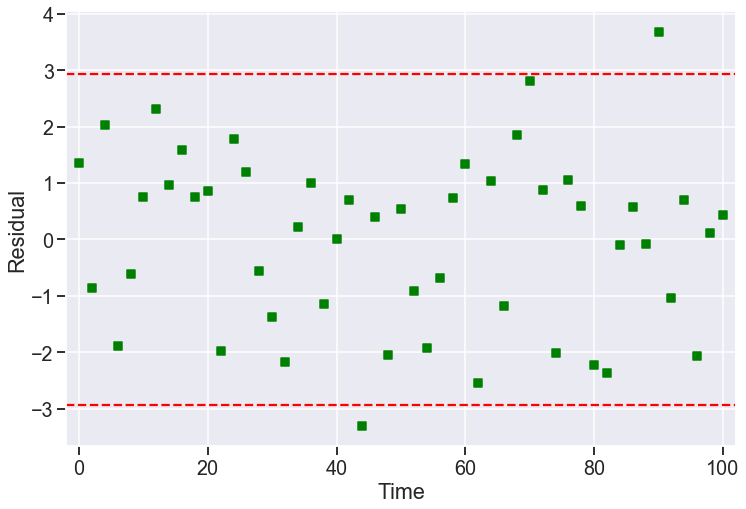

In [67]:
with sns.plotting_context('talk', font_scale=1.2):
    _, ax = plt.subplots(figsize=(12,8 ))
    plt.scatter(time_data, residuals, s=50, c='g', marker="s")
    plt.hlines(sigma_noise*1.96, -2, 102, linestyle='dashed', colors='r')
    plt.hlines(sigma_noise*-1.96, -2, 102, linestyle='dashed', colors='r')
    plt.ylabel('Residual')
    plt.xlabel('Time')
    plt.xlim([-2, 102]);

In [68]:
sigma_error_square = (1/(len(time_data)-1))*ss_min
print(f"Actual standard deviation of the noise: {sigma_noise}\nEstimated standard deviation of the noise {np.sqrt(sigma_error_square):0.2f}")
# sigma_error_square = (1/(len(time_data)-1))* np.transpose(residuals)@residuals       Equivalent method

Actual standard deviation of the noise: 1.5
Estimated standard deviation of the noise 1.55


### Two parameters are unknown and need to be inferenced: $\tau$ and $\sigma$

In [69]:
# model expected value of the response is normally distributed with mean being the nonlinear function with unknown parameter and sd unknown with the data acting as our observations 


with pm.Model() as model_g:
    τ = pm.Uniform('τ', 0, 100)
    ϵ = pm.HalfNormal('ϵ', 5)
#     ν = pm.Exponential('ν', 1/30)
#     ϵ = pm.Uniform('ϵ', 0, 5)
#     μ = pm.Deterministic('μ', newton_cooling(τ, T_0, T_env, time_data))
#     T_pred = pm.StudentT('T_pred', mu=μ, sd=ϵ, nu=ν, observed=T_data)
#      epsilon = pm.Normal('eps', mu=0, sd=ϵ, observed=T_data - μ)
    T_pred = pm.Normal('T_pred', mu=newton_cooling(τ, T_0, T_env, time_data), sd=ϵ, observed=T_data)


    trace_g = pm.sample(2000, tune=1000,cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, τ]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:04<00:00, 1238.53draws/s]


In [70]:
az.summary(trace_g)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
τ,19.775,0.294,19.244,20.347,0.005,0.003,3555.0,3555.0,3571.0,2457.0,1.0
ϵ,1.586,0.162,1.288,1.887,0.003,0.002,3406.0,3294.0,3544.0,2662.0,1.0


In [71]:
chain_count =  trace_g.get_values('τ').shape[0]
y_pred_g = pm.sample_posterior_predictive(trace_g, samples=chain_count, model=model_g)
data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)

100%|██████████| 4000/4000 [00:04<00:00, 882.76it/s]


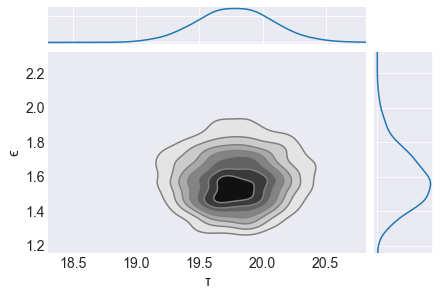

In [72]:
az.plot_joint(data_ppc,var_names=['τ', 'ϵ'], kind='kde', fill_last=False);

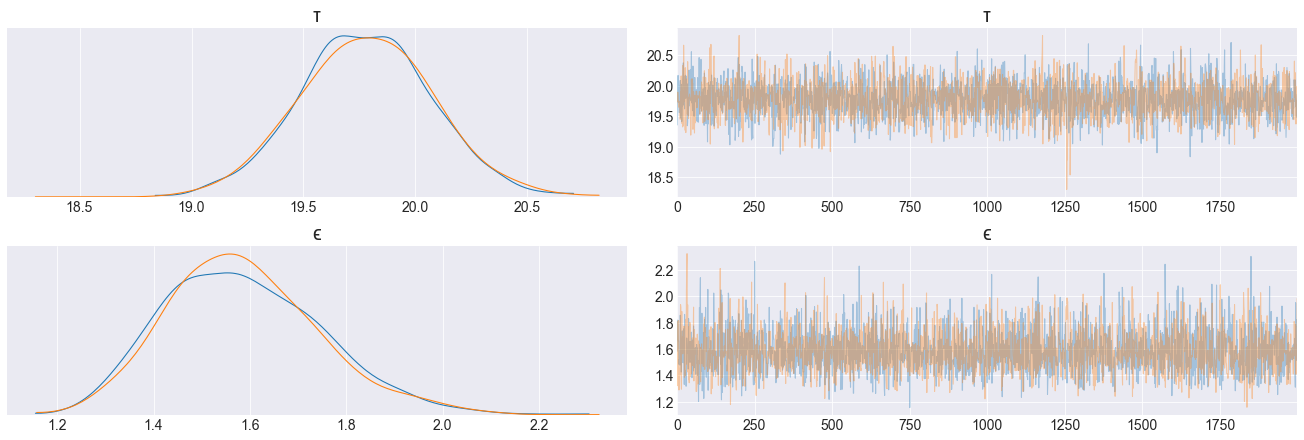

In [73]:
figure1 = az.plot_trace(trace_g, var_names=[ 'τ', 'ϵ'], figsize=(18, 6));

# get and change x labels
for i in range(figure1.shape[0]):
    for j in range(figure1.shape[1]):
        if j==0:
            x_labels = [str(np.round(x,3)) for x in figure1[i][j].get_xticks()];
            figure1[i][j].set_xticklabels(x_labels, fontsize=14);
            
        if j==1:
            y_labels = [str(np.round(y,3)) for y in figure1[i][j].get_yticks()];
            figure1[i][j].set_yticklabels(y_labels, fontsize=14);
            
            x_labels = [str(int(x)) for x in figure1[i][j].get_xticks()];
            figure1[i][j].set_xticklabels(x_labels, fontsize=14);
            
        title=figure1[i][j].get_title()
        figure1[i][j].set_title(title, fontsize=20);
        


In [77]:
CriL_ppc = np.percentile(y_pred_g["T_pred"],q=2.5,axis=0)  # grab quantiles
CriU_ppc = np.percentile(y_pred_g["T_pred"],q=97.5,axis=0)  # grab quantiles
mean_ppc = np.mean(y_pred_g["T_pred"], axis=0)

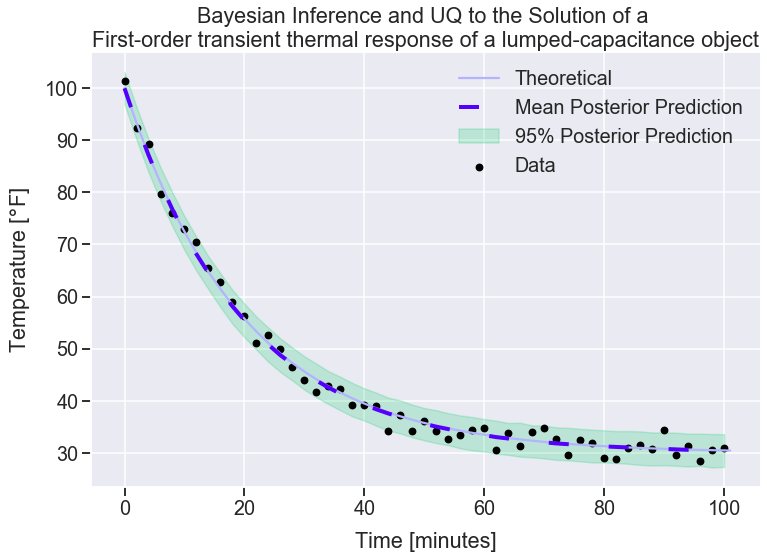

In [183]:
with sns.plotting_context('talk', font_scale=1.2):
    _, ax = plt.subplots(figsize=(12,8 ))
    plt.plot(time, newton_cooling(tau, T_0, T_env,time), color='#b3b3ff')
    plt.plot(time_data, mean_ppc,linestyle='--',dashes=(5, 10), linewidth=4, color="#5500ff")
    plt.fill_between(time_data, CriL_ppc, CriU_ppc, alpha=0.2, color="#00cc66")
    plt.scatter(time_data, T_data, c='k',s=40)
    plt.legend(['Theoretical', 'Mean Posterior Prediction' ,'95% Posterior Prediction', 'Data', ])
    plt.ylabel(r'Temperature [$\degree$F]', labelpad=13)
    plt.xlabel('Time [minutes]',labelpad=13)
    plt.title('Bayesian Inference and UQ to the Solution of a \nFirst-order transient thermal response of a lumped-capacitance object' )
#     for prediction in ppc["T_pred"]:
#         plt.plot(time_data, prediction, alpha=0.4)

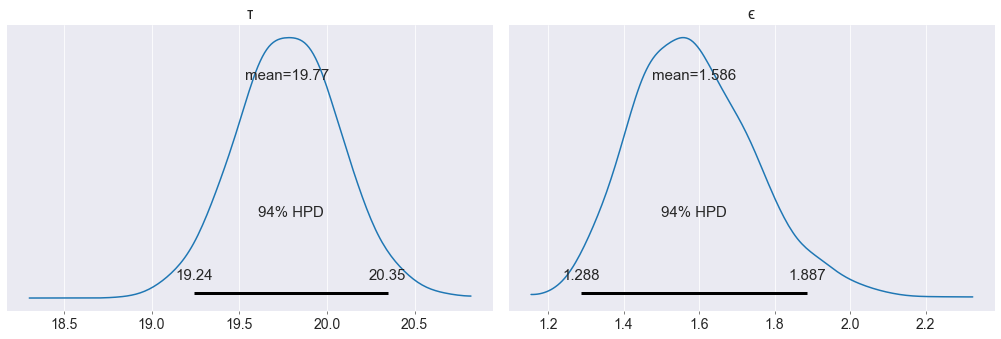

In [79]:
pm.plot_posterior(data_ppc, point_estimate='mean',round_to=4);

In [51]:
grad_newton = grad(newton_cooling, 0)
grad_newton_values = [grad_newton(tau_opt,T_0, T_env, time) for time in time_data]
grad_newton_values= np.asarray(grad_newton_values)

delta_k = 1 / (np.transpose(grad_newton_values)@grad_newton_values)
t_inv = stats.t.ppf(1-0.05/2, len(time_data)-1)


tau_freq_LB, tau_freq_UB = tau_opt - t_inv*np.sqrt(sigma_error_square)*np.sqrt(delta_k), tau_opt + t_inv*np.sqrt(sigma_error_square)*np.sqrt(delta_k)

print(f'{tau_freq_LB}', tau_freq_UB)


19.21395500136193 20.33211170613407


In [59]:
CI = []
PI = []
S_xx = np.sum((time_data-np.mean(time_data))**2)
x_mean = np.mean(time_data)
n=len(time_data)
for i in range(0, n):
    CI.append(t_inv * np.sqrt(sigma_error_square) * np.sqrt(1/n + ((time_data[i]-x_mean)**2 / ((n-1)*S_xx))))
    PI.append(t_inv * np.sqrt(sigma_error_square) * np.sqrt(1 + 1/n + ((time_data[i]-x_mean)**2 / ((n-1)*S_xx))))

T_expected = newton_cooling(tau_opt, T_0, T_env,time_data)    

### How does Frequentists UQ approach compare the Bayesian Approach?

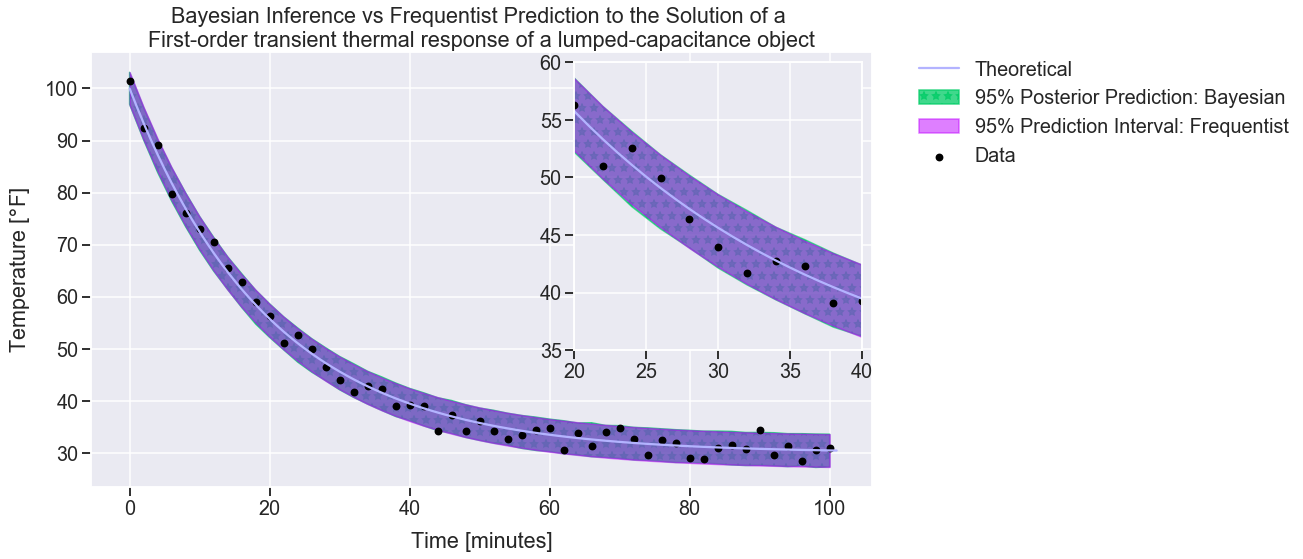

In [182]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
with sns.plotting_context('talk', font_scale=1.2):
    _, ax = plt.subplots(figsize=(14,8))
    plt.plot(time, newton_cooling(tau, T_0, T_env,time),color='#b3b3ff')
    plt.fill_between(time_data, CriL_ppc, CriU_ppc, alpha=0.75, hatch="*", color= "#00cc66")
    plt.fill_between(time_data, T_expected + PI , T_expected - PI, alpha=0.5, color='#bf00ff')
    plt.scatter(time_data, T_data, c='k',s=40)
#     plt.legend()
    plt.ylabel(r'Temperature [$\degree$F]', labelpad=13)
    plt.xlabel('Time [minutes]',labelpad=13)
    plt.title('Bayesian Inference vs Frequentist Prediction to the Solution of a \nFirst-order transient thermal response of a lumped-capacitance object' )
    plt.legend(['Theoretical', '95% Posterior Prediction: Bayesian' ,'95% Prediction Interval: Frequentist', 'Data', ], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    axins = inset_axes(ax, width=4, height=4)
    axins.plot(time, newton_cooling(tau, T_0, T_env,time),color='#b3b3ff')
    axins.fill_between(time_data, CriL_ppc, CriU_ppc, alpha=0.65, hatch="*", color= "#00cc66")
    axins.fill_between(time_data, T_expected + PI , T_expected - PI, alpha=0.5, color='#bf00ff')
    axins.set_xticks([20, 25, 30, 35, 40])
    axins.scatter(time_data, T_data, c='k',s=40)
    plt.xlim([20, 40])
    plt.ylim([35, 60])


    
#     _, ax = plt.subplots(figsize=(14,8))
#     plt.plot(time, newton_cooling(tau, T_0, T_env,time),color='#b3b3ff')
#     plt.fill_between(time_data, CriL_ppc, CriU_ppc, alpha=0.75, hatch="*", color= "#00cc66")
#     plt.fill_between(time_data, T_expected + PI , T_expected - PI, alpha=0.5, color='#bf00ff')
#     plt.scatter(time_data, T_data, c='k',s=40)
#     plt.legend(['Theoretical', 'Mean Posterior Prediction' ,'95% Posterior Prediction', 'Data', ])
#     plt.ylabel(r'Temperature [$\degree$F]', labelpad=13)
#     plt.xlabel('Time [minutes]',labelpad=13)
#     plt.title('Bayesian Inference to the Solution of a \nFirst-order transient thermal response of a lumped-capacitance object' )
#     plt.xlim([20, 60])
#     plt.ylim([30, 60])